In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import rasterio
import rasterio.plot

import rioxarray as rxr
import xarray as xr

import matplotlib.pyplot as plt

from bio_optics.helper import utils

In [2]:
def open_EnMAP_data_visible(path, fnames, plotRGB=False):
    # Image files
    img_name = fnames
    img_folder = path + fnames
    img_tif = img_name + "-SPECTRAL_IMAGE.TIF"
    img_meta = img_name + "-METADATA.XML"
    tiff_rgb = img_name + "-QL_VNIR.TIF"
    img_data = os.path.join(img_folder, img_tif)
    img_rgb = os.path.join(img_folder, tiff_rgb)
    xml_file = os.path.join(img_folder, img_meta)
    rgb = os.path.join(img_folder, img_rgb)
    
    img_masks = os.path.join(img_folder, img_name + "-QL_QUALITY_CLASSES.TIF")

    print('Processing image: {}'.format(img_name[12:]))
    print()

    ###############################################################################
    '''                           --- Metadata ---                              '''
    ###############################################################################

    print('Reading metadata...')
    print('')
    print('Getting info about SZ Angles, AC Type, Water Type, Version')
    print('')

    '''---------------- SZ Angles,Sensor Geometry & AC metadata ----------------'''

    search_pattern = ['<waterType>', '<revision>', '<season>', '<biomeType>',
                      '<orbitDirection>', '<sunElevationAngle>', '<sunAzimuthAngle>',
                      '<acrossOffNadirAngle>', '<alongOffNadirAngle>', '<sceneAzimuthAngle>']

    closing_tag = ['</waterType>', '</revision>', '</season>', '</biomeType>',
                   '</orbitDirection>', '</center>', '</center>', '</center>', '</center>', '</center>']

    # Set the length of angles based on the length of search_pattern
    angles = [''] * len(search_pattern)
    meta = [''] * len(search_pattern)

    # Open the XML file for reading
    with open(xml_file, 'r', encoding='utf-8') as file:
        # Read the contents of the file
        xml_content = file.read()

        # Check if <sunElevationAngle> is present in line 1180
        if '<sunElevationAngle>' in xml_content.splitlines()[1169]:
            # If <sunElevationAngle> is present, set lines_to_extract accordingly
            lines_to_extract = [1175, 1182, 1189, 1196, 1203]
        else:
            # If <sunElevationAngle> is not present, set lines_to_extract accordingly
            lines_to_extract = [1185, 1192, 1199, 1206, 1213]

            # Extract the values from the specified lines
        for line_number in lines_to_extract:
            line = xml_content.splitlines()[line_number - 1]  # Adjusting for 0-based indexing
            start_index = line.find('<center unit="DEG">') + len('<center unit="DEG">')
            end_index = line.find('</center>', start_index)

            if start_index != -1 and end_index != -1:
                extracted_value = line[start_index:end_index].strip()
                angles.append(extracted_value)

        # Extract the meta information
        for i in range(len(search_pattern)):
            # Find the position of the opening and closing tags
            start_index = xml_content.find(search_pattern[i])
            end_index = xml_content.find(closing_tag[i], start_index)

            # Extract the text between the tags
            if start_index != -1 and end_index != -1:
                start_index += len(search_pattern[i])
                if 5 <= i <= 9:  # Check if the index is between 5 and 9 (inclusive)
                    meta[i] = angles[i - 5]  # Replace with the extracted center value
                else:
                    meta[i] = xml_content[start_index:end_index]

    # - Save the data for inclunding it later with spectra
    metadata_vars = meta[:5] + angles[10:]

    del search_pattern, closing_tag, angles, meta, lines_to_extract, line_number, line
    del start_index, end_index

    '''---------------------- Central Wavelengths of bands ----------------------'''

    print('Checking central wavelengths of bands...')
    print('')

    start_line = 1264
    end_line = 2607

    # List to store all the extracted wavelength center values
    wvl = []

    # Open the XML file for reading
    with open(xml_file, 'r', encoding='utf-8') as file:
        # Read the contents of the file
        lines = file.readlines()

        # Flag to indicate whether the current line is within the specified range
        within_range = False

        # Iterate through all lines
        for line_number, line in enumerate(lines, start=1):
            # Check if the current line is within the specified range
            if start_line <= line_number <= end_line:
                within_range = True
            else:
                within_range = False

            # Extract the values if the line contains the specified pattern
            if within_range and '<wavelengthCenterOfBand>' in line:
                start_index = line.find('<wavelengthCenterOfBand>') + len('<wavelengthCenterOfBand>')
                end_index = line.find('</wavelengthCenterOfBand>', start_index)

                if start_index != -1 and end_index != -1:
                    extracted_value = line[start_index:end_index].strip()
                    float_value = float(extracted_value)
                    wvl.append(float_value)

    wvl = np.array(wvl)

    # - Select only the necessary wavelengths
    wavelengths = wvl[:80]

    del start_line, end_line, extracted_value, float_value, line, line_number, lines, start_index, end_index
    del within_range

    ###############################################################################
    '''                         --- Image ---                                '''
    ###############################################################################

    print('Opening image...')
    print()

    # Image data
    ds = rxr.open_rasterio(img_data)

    # Convert to 3D Array (Only taking until band 80 = 903.87 nm)
    im_array = np.array(ds).astype(float)[:80, :, :]

    # Rescale values to Rrs (EnMAP Gain = 10000)
    img_rss = im_array.copy() / 10000

    ###############################################################################
    '''                         --- Masks ---                                '''
    ###############################################################################

    print('Opening masks...')
    print()
    mask = rxr.open_rasterio(img_masks)
    
    if plotRGB:
        ###############################################################################
        '''                           --- RGB  ---                                  '''
        ###############################################################################

        # - Plot RGB
        rgb_array = rxr.open_rasterio(img_rgb).values
        reshaped_array = rgb_array.transpose(1, 2, 0).reshape((rgb_array.shape[1], rgb_array.shape[2], -1))
        rgb = reshaped_array[:, :, :-1]
        plt.imshow(rgb)

        # - Select & Visualize Subset
        roi_rgb = np.copy(rgb)

        # Define the coordinates for subset
        x_start, x_end = 600, 700
        y_start, y_end = 450, 550

        # Set the color for the square
        red = [255, 0, 0]

        # Draw the horizontal lines
        roi_rgb[x_start:x_start + 2, y_start:y_end, :] = red
        roi_rgb[x_end - 2:x_end, y_start:y_end, :] = red
        # Draw the vertical lines
        roi_rgb[x_start:x_end, y_start:y_start + 2, :] = red
        roi_rgb[x_start:x_end, y_end - 2:y_end, :] = red

        # Plot
        plt.imshow(roi_rgb)
        plt.show()

    return img_rss, wavelengths, mask

In [3]:
###
# read in EnMAP L2A data
path = "Y:\EnMAP\L2A_Water\V0103\Images\\"
fnames = "ENMAP01-____L2A-DT0000035300_20230815T111713Z_003_V010303_20230816T082319Z"

enmap, wl, waterMask = open_EnMAP_data_visible(path, fnames)

print(enmap.shape)
print(wl)

Processing image: L2A-DT0000035300_20230815T111713Z_003_V010303_20230816T082319Z

Reading metadata...

Getting info about SZ Angles, AC Type, Water Type, Version

Checking central wavelengths of bands...

Opening image...

Opening masks...

(80, 1250, 1273)
[418.416 424.043 429.457 434.686 439.758 444.699 449.539 454.306 459.031
 463.73  468.411 473.08  477.744 482.411 487.087 491.78  496.497 501.243
 506.02  510.829 515.672 520.551 525.467 530.424 535.422 540.463 545.551
 550.687 555.873 561.112 566.405 571.756 577.166 582.636 588.171 593.773
 599.446 605.193 611.017 616.923 622.921 628.987 635.112 641.294 647.537
 653.841 660.207 666.637 673.131 679.691 686.319 693.014 699.78  706.617
 713.524 720.501 727.545 734.654 741.826 749.06  756.353 763.703 771.108
 778.567 786.078 793.639 801.249 808.905 816.608 824.355 832.145 839.976
 847.847 855.757 863.703 871.683 879.693 887.729 895.789 901.961]


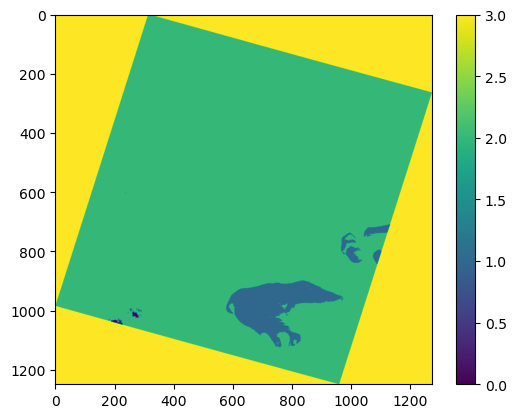

In [140]:
# b = np.array(waterMask[ :, :]).reshape((height*width,))
# plt.hist(b)
plt.imshow(waterMask[0,:, :])
plt.colorbar()
plt.show()

-3.2768 -3.2768


C:\Users\Dagmar\AppData\Local\Temp\ipykernel_9484\1248126583.py:14: RuntimeWarning: divide by zero encountered in log10
  ax[1].hist(np.log10(b), bins)
C:\Users\Dagmar\AppData\Local\Temp\ipykernel_9484\1248126583.py:14: RuntimeWarning: invalid value encountered in log10
  ax[1].hist(np.log10(b), bins)


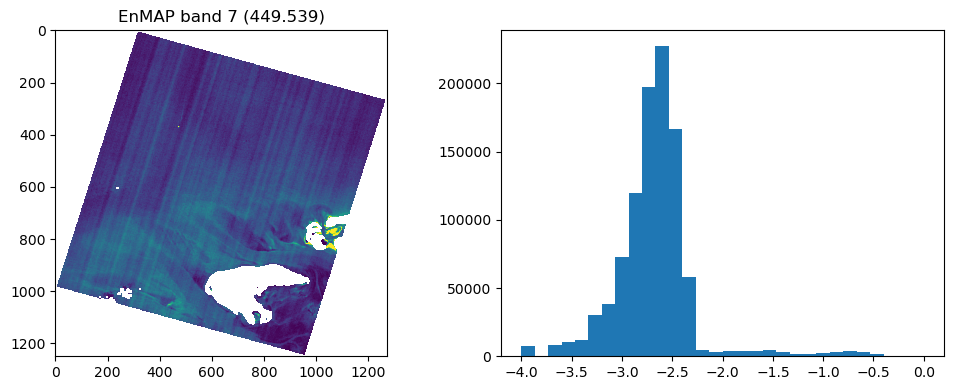

In [4]:
bandNo = 6
a = np.copy(enmap[bandNo,:, :])
minVal = np.nanmin(a)
print(minVal, np.min(a))
ID = np.array(a == minVal)
a[ID] = np.nan
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
a_m = np.ma.masked_where(waterMask[0,:, :] !=2, a)
ax[0].imshow(a_m, vmin=0., vmax=0.01)
ax[0].set_title('EnMAP band ' + str(int(bandNo+1)) + " ("+ str(wl[bandNo]) + ")")
# ax[0].colorbar()
bins = np.linspace(-4, 0., 31)
b = np.reshape(a, (a.shape[0]*a.shape[1],))
ax[1].hist(np.log10(b), bins)
fig.tight_layout()
plt.show()


# Step 1: Bridging satellite to model

## Setting up the input data

In [5]:
Nbands = 60
inputNN = np.copy(enmap[:Nbands, :, :])

minVal = -3.2768 # NaN value
ID = np.array(inputNN == minVal)
inputNN[ID] = np.nan
print(np.nanmin(inputNN[6,:, :]))
# plt.imshow(inputNN[6,:, :], vmin=0., vmax=0.01)
# plt.show()

validInput = np.sum(np.isnan(inputNN), axis=0)
for i in range(Nbands):
    # ID = np.logical_and(np.array(validInput <10), np.isnan(inputNN[i,:,:])) # does not occur
    # inputNN[i, ID] = 0.0001
    ID = np.array(inputNN[i,:,:] < 0)
    print(i, np.sum(ID))

print(validInput.shape)
height, width = validInput.shape

## repeat after filling some gaps
validInput = np.sum(np.isnan(inputNN), axis=0)
validInput = np.array(validInput == 0)
print(np.sum(validInput), height*width)

-0.0395
0 3664
1 5957
2 6734
3 5513
4 5855
5 5510
6 5329
7 5297
8 5305
9 5078
10 5221
11 5232
12 5325
13 5374
14 5812
15 5787
16 5924
17 5537
18 5070
19 3875
20 2939
21 2170
22 1576
23 1246
24 1026
25 898
26 829
27 767
28 722
29 776
30 900
31 1101
32 1306
33 1403
34 1617
35 1721
36 1629
37 1631
38 1733
39 1907
40 1992
41 2083
42 2056
43 2268
44 3007
45 3755
46 4103
47 4505
48 4812
49 4441
50 3553
51 1765
52 236
53 25
54 27
55 48
56 54
57 57
58 53
59 34
(1250, 1273)
1027631 1591250


## Apply NN

In [7]:
NNpath1 = "E:\Documents\projects\EnsAD\\NN_training\\NN_EnMAP2Model\\nn_EnMAP_20240408_v01\I60x100x100x100x100xO60__v2\\temp\\"
modelFname = 'I60x100x100x100x100xO60batch20_epoch40000_loss0.04693.h5'
model_bridge = tf.keras.models.load_model(NNpath1 + modelFname)

inputNN2 = np.zeros((np.sum(validInput), 60))
for i in range(Nbands):
    inputNN2[:, i] = inputNN[i, validInput]

print(inputNN2.shape)
## run NN prediction: EnMAP Rrs to Model Rrs
NNbridge_pred = model_bridge.predict(inputNN2)

outRrs = np.zeros((60, height, width)) + np.nan
for i in range(60):
    outRrs[i, validInput] = NNbridge_pred[:, i]


(1027631, 60)
32114/32114 [==============================] - 52s 2ms/step


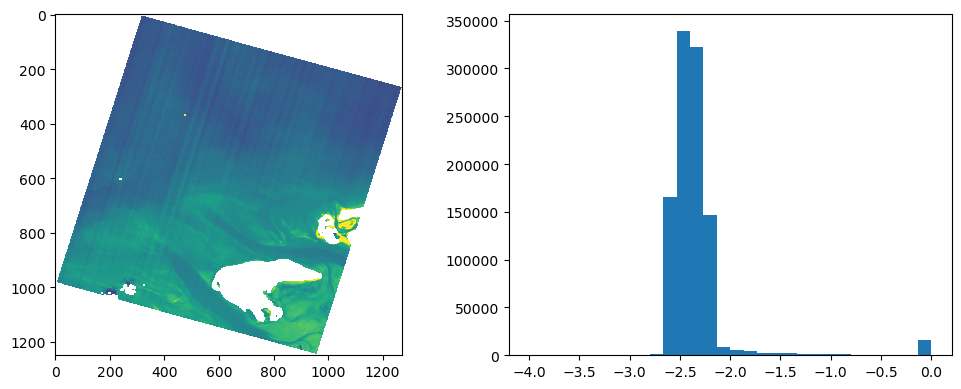

In [8]:
a = outRrs[6,:, :]
# ID = np.array(a < 0)
# a[ID] = np.nan
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
a_m = np.ma.masked_where(waterMask[0,:, :] !=2, a)
ax[0].imshow(a_m, vmin=0., vmax=0.01)
# ax[0].colorbar()
b = np.reshape(a, (a.shape[0]*a.shape[1],))
ID2= np.array(b>0)
bins = np.linspace(-4, 0., 31)
ax[1].hist(np.log10(b[ID2]), bins)
fig.tight_layout()
plt.show()

## Errors in Bridging

In [9]:
rMAE_nn = np.sqrt(np.sum((inputNN2 - NNbridge_pred)**2, axis=1)) / np.sum(inputNN2, axis=1)
rMAE_nn_2d = np.zeros((height, width)) + np.nan
rMAE_nn_2d[validInput] = rMAE_nn
print(rMAE_nn_2d.shape)

(1250, 1273)


C:\Users\Dagmar\AppData\Local\Temp\ipykernel_9484\1086368031.py:1: RuntimeWarning: divide by zero encountered in divide
  rMAE_nn = np.sqrt(np.sum((inputNN2 - NNbridge_pred)**2, axis=1)) / np.sum(inputNN2, axis=1)


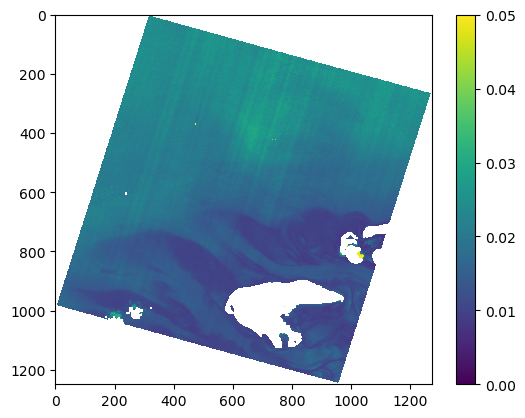

In [10]:
a_m = np.ma.masked_where(waterMask[0,:, :] !=2, rMAE_nn_2d)
plt.imshow(a_m, vmin=0., vmax=0.05)
plt.colorbar()
plt.show()

# Step 2: Rrs to IOP

In [11]:
def transform_NorthSea_IOPs(iopArr, reverse = False):
    # set fixed IOP values, for variable: 'C_0', 'C_2', 'C_5', 'C_6', 'C_7', 'C_Y', 'C_ism', 'L_fl_lambda0', 'b_ratio_md', 'b_ratio_bd', 'S_cdom'
    varList = ['C_0', 'C_2', 'C_5', 'C_6', 'C_7', 'C_Y', 'C_ism', 'L_fl_lambda0', 'b_ratio_md', 'b_ratio_bd', 'S_cdom']
    rangeDict = {
        'C_0': [0., 1000.],
        'C_2': [0., 1000.],
        'C_5': [0., 1000.],
        'C_6': [0., 1000.],
        'C_7': [0., 1.],
        'C_Y': [0., 2.],
        'C_ism': [0., 100.],
        'L_fl_lambda0': [0., 0.2],
        'b_ratio_md': [0.021, 0.3756],
        'b_ratio_bd': [0.021, 0.3756],
        'S_cdom': [0.005, 0.032]
    }

    iopArrT = np.zeros(iopArr.shape)
    for i, v in enumerate(varList):
        delta = rangeDict[v][1] - rangeDict[v][0]
        if reverse:
            iopArrT[:, i] = iopArr[:, i]*delta + delta / 2.
        else:
            iopArrT[:, i] = (iopArr[:, i] - delta / 2.) / delta

    return iopArrT

In [12]:
path = "E:\Documents\projects\EnsAD\\NN_training\\NN_ModelRrs2IOP\\nn_EnMAP_20240408_v01\I60x80x80x80xO11_IOP_NorthSea_ranges_MinRrsIOPTrans\\temp\\"
fname = 'I60x80x80x80xO11_batch10_epoch17623_loss0.00142.h5'
model_IOP = tf.keras.models.load_model(path + fname)

IOPNN_pred = model_IOP.predict(NNbridge_pred)
IOPNN_pred = transform_NorthSea_IOPs(IOPNN_pred, reverse=True)

Niop = IOPNN_pred.shape[1]
outIOP = np.zeros((Niop, height, width)) + np.nan
for i in range(Niop):
    outIOP[i, validInput] = IOPNN_pred[:, i]

32114/32114 [==============================] - 49s 2ms/step


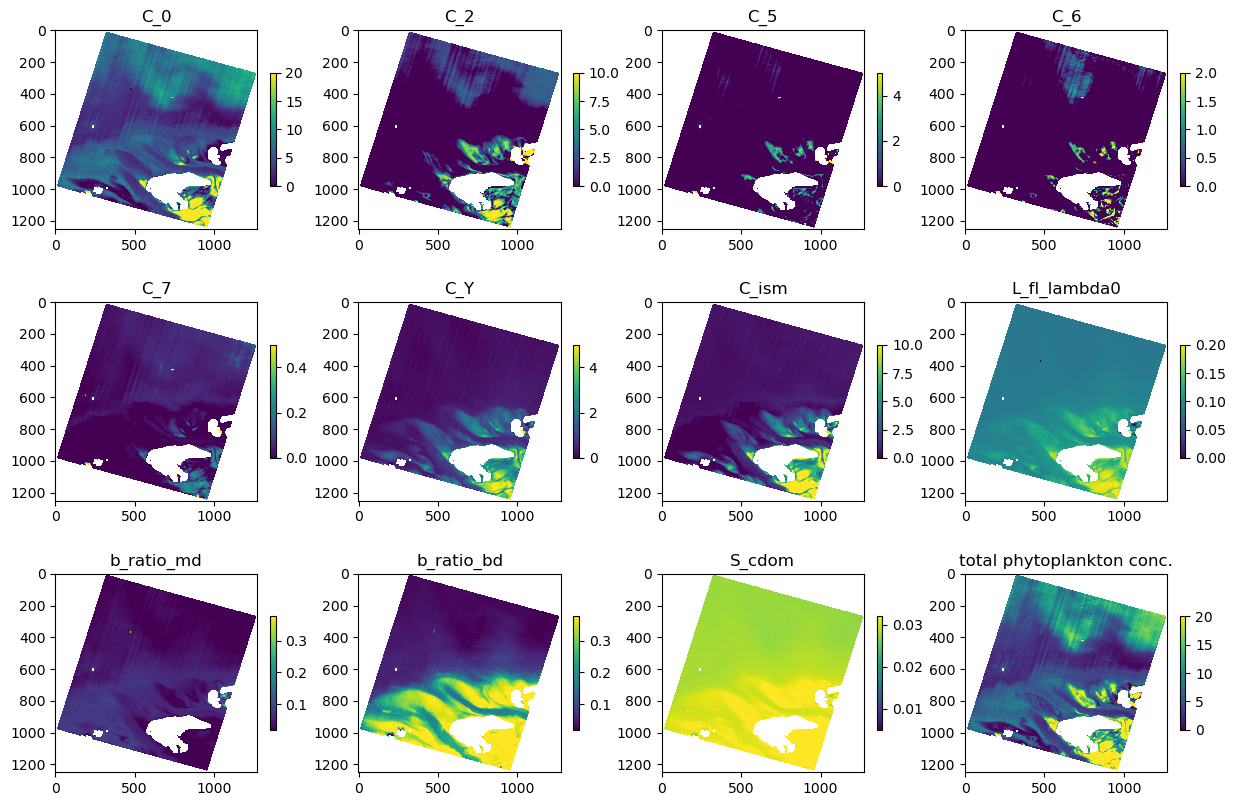

In [13]:
varList = ['C_0', 'C_2', 'C_5', 'C_6', 'C_7', 'C_Y', 'C_ism', 'L_fl_lambda0', 'b_ratio_md', 'b_ratio_bd', 'S_cdom']
rangeList = [[0,20], [0,10], [0, 5], [0,2], [0, 0.5], [0,5], [0, 10], [0, 0.2], [0.021, 0.3756], [0.021, 0.3756], [0.005, 0.032]]
Nx, Ny = (4, 3)
fig, ax = plt.subplots(nrows=Ny, ncols=Nx, figsize=(15, 10))
ix, iy = (0, 0)

for i in range(len(varList)):
    a_m = np.ma.masked_where(waterMask[0,:, :] !=2, outIOP[i,:,:])
    im = ax[iy, ix].imshow(a_m, vmin=rangeList[i][0], vmax=rangeList[i][1])
    fig.colorbar(im, ax=ax[iy,ix], shrink=0.5)
    ax[iy, ix].set_title(varList[i])
    ix +=1
    if ix == Nx:
        ix=0
        iy+=1

#total phytoplankton conc.
b = np.copy(outIOP[0:5,:,:])
ID = np.array(b < 0)
b[ID] = 0.
a_m = np.ma.masked_where(waterMask[0,:, :] !=2, np.sum(b, axis=0))
im = ax[iy, ix].imshow(a_m, vmin=0., vmax=20.)
fig.colorbar(im, ax=ax[iy,ix], shrink=0.5)
ax[iy, ix].set_title('total phytoplankton conc.')
ix +=1
if ix == Nx:
    ix=0
    iy+=1


while iy < Ny:
    ax[iy, ix].axis('off')
    ix +=1
    if ix == Nx:
        ix=0
        iy+=1
    
plt.show()

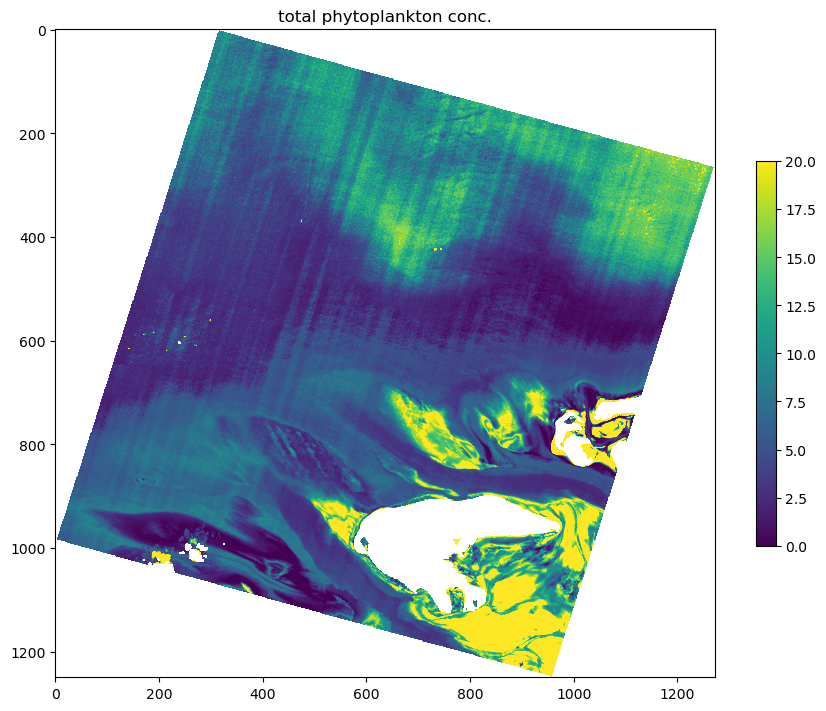

In [14]:
#total phytoplankton conc.
b = np.copy(outIOP[0:5,:,:])
ID = np.array(b < 0)
b[ID] = 0.
a_m = np.ma.masked_where(waterMask[0,:, :] !=2, np.sum(b, axis=0))
fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(9,8))
im = ax.imshow(a_m, vmin=0., vmax=20.)
fig.colorbar(im, ax=ax, shrink=0.5)
ax.set_title('total phytoplankton conc.')
fig.tight_layout()
image_outpath = "Z:\projects\ongoing\EnsAD\\meeting\\2024-04-16_18_EARSel_Workshop_Valencia\presentation\\"
fnames = "ENMAP01-____L2A-DT0000035300_20230815T111713Z_003_V010303_20230816T082319Z"
# plt.savefig(image_outpath + "totalPhyto_"+ fnames+".png", dpi=300)
# plt.close()
plt.show()

## Error estimate optical closure

In [15]:
fwnn_path =  "E:\Documents\projects\EnsAD\\NN_training\\NN_IOP2ModelRrs_fwHEREON\\fwnn_HEREON_20240409_v01\I11x110x70x60xO60_IOP_NorthSea_ranges_l1RegTrans\\temp\\"
fname = 'I11x110x70x60xO60_batch10_epoch39064_loss0.0.h5'

model_fw = tf.keras.models.load_model(fwnn_path + fname)

IOPNN_pred = transform_NorthSea_IOPs(IOPNN_pred, reverse=False)
RrsNN_pred = model_fw.predict(IOPNN_pred)

32114/32114 [==============================] - 46s 1ms/step


In [26]:
rMAE_fwnn = np.sqrt(np.sum((inputNN2 - RrsNN_pred)**2, axis=1)) / np.sum(inputNN2, axis=1)
rMAE_fwnn_2d = np.zeros((height, width)) + np.nan
rMAE_fwnn_2d[validInput] = rMAE_fwnn

MAE_fwnn = np.mean(np.abs(inputNN2 - RrsNN_pred), axis=1)
MAE_fwnn_2d = np.zeros((height, width)) + np.nan
MAE_fwnn_2d[validInput] = MAE_fwnn

C:\Users\Dagmar\AppData\Local\Temp\ipykernel_9484\1246973124.py:1: RuntimeWarning: divide by zero encountered in divide
  rMAE_fwnn = np.sqrt(np.sum((inputNN2 - RrsNN_pred)**2, axis=1)) / np.sum(inputNN2, axis=1)


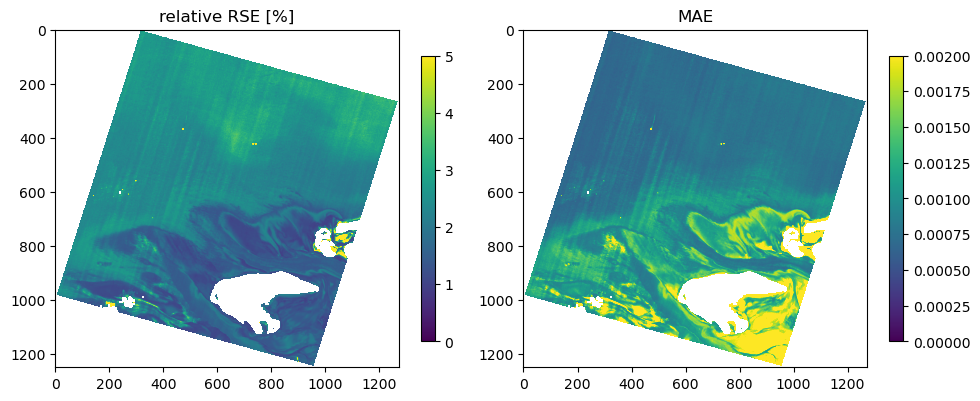

In [33]:
# ID = np.logical_and(np.array(rMAE_fwnn >0), np.array(rMAE_fwnn<100))
# plt.hist(np.log10(rMAE_fwnn[ID]), 50)
# plt.show()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
a_m = np.ma.masked_where(waterMask[0,:, :] !=2, rMAE_fwnn_2d)
im = ax[0].imshow(a_m*100., vmin=0., vmax=5)
ax[0].set_title('relative RSE [%]')
fig.colorbar(im, ax=ax[0], shrink=0.8)
a_m = np.ma.masked_where(waterMask[0,:, :] !=2, MAE_fwnn_2d)
im = ax[1].imshow(a_m, vmin=0., vmax=0.002)
ax[1].set_title('MAE')
fig.colorbar(im, ax=ax[1], shrink=0.8)
fig.tight_layout()
plt.show()